In [1]:
# Cube Alchemy AdventureWorks Demo
import pandas as pd
from cube_alchemy import Hypercube
import matplotlib.pyplot as plt

from pathlib import Path

current_dir = Path.cwd()
#print(f"Current working directory: {current_dir}")

In [2]:
from tables import tables
print(tables.keys())

dict_keys(['accounts', 'actuals', 'budget', 'business_unit_dim', 'calendar_dim', 'cost_center_dim', 'location_dim', 'pnl_report_mapping', 'project_dim', 'vendor_dim'])


In [3]:
# rename amount columns in all tables to "amount (table_name)"
for table_name, df in tables.items():
    if 'amount' in df.columns:
        df.rename(columns={'amount': f'amount ({table_name})'}, inplace=True)
    # if 'account_number' convert into a int and then into a str
    if 'account_number' in df.columns:
        df['account_number'] = df['account_number'].astype(int).astype(str)


Initializing DataModel with provided tables...
Hypercube initialization failed due to cyclic relationships or other issues.
Visualizing the original tables graph:



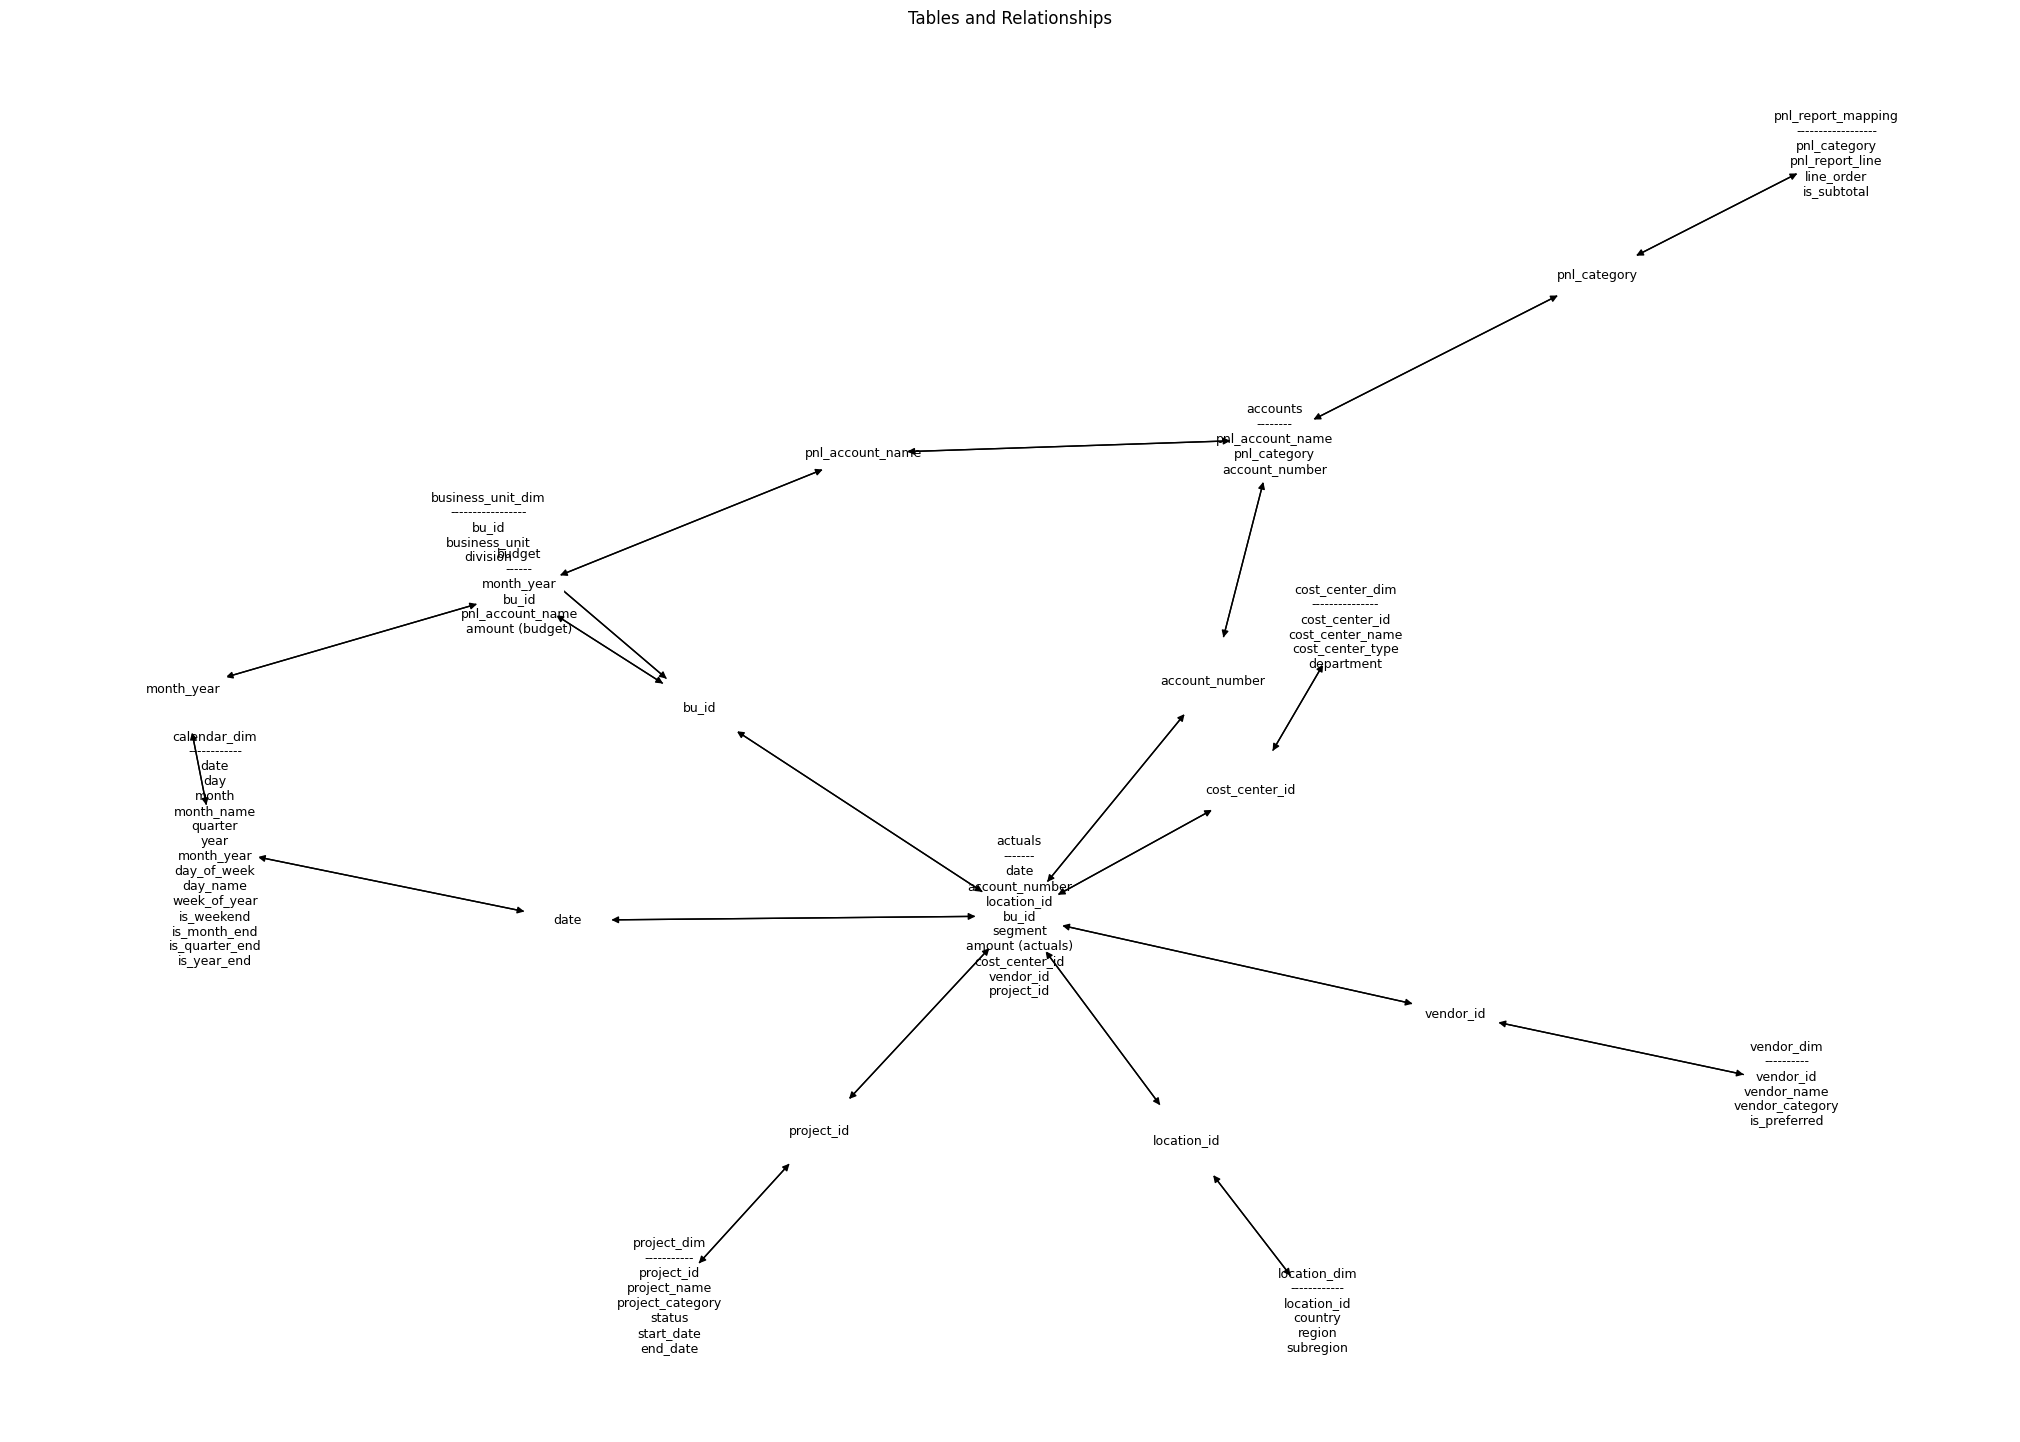


Relationships after initialization with composite tables:
Cyclic relationships detected in the hypercube: budget -> calendar_dim -> actuals -> accounts
DataModel initialization failed: Cyclic relationships detected in the hypercube
Error creating Hypercube: Cyclic relationships detected in the hypercube


In [4]:
import copy
tables_working = copy.deepcopy(tables)
try:
    cube = Hypercube(tables_working)
except Exception as e:
    print("Error creating Hypercube:", e)

In [5]:
actuals_prep = pd.merge(
    tables_working['actuals'][['date', 'account_number', 'bu_id']].drop_duplicates(),
    tables_working['calendar_dim'][['date', 'month_year']],
    on='date',
    how='left'
)

# Add pnl_account_name to actuals for linking with budget
actuals_dims = pd.merge(
    actuals_prep,
    tables_working['accounts'][['account_number', 'pnl_account_name']].drop_duplicates(),
    on='account_number',
    how='left'
).drop_duplicates()

# Step 2.2: Prepare budget dimension data
budget_dims = tables_working['budget'][['month_year', 'pnl_account_name', 'bu_id']].drop_duplicates()


# Step 2.3: Create the initial fact_link table with all distinct dimensions
# This creates one row for each unique combination of dimension values
fact_link_dims = pd.DataFrame()

# Add all distinct dimension values from actuals
fact_link_dims = pd.concat([
    fact_link_dims,
    actuals_dims
])

# Add all distinct dimension values from budget
fact_link_dims = pd.concat([
    fact_link_dims,
    budget_dims
])

# Remove duplicates to get unique combinations
fact_link_dims = fact_link_dims.drop_duplicates().reset_index(drop=True)

# Ensure consistent data types for key creation
fact_link_dims['account_number'] = fact_link_dims['account_number'].astype(str)
fact_link_dims['bu_id'] = fact_link_dims['bu_id'].astype(str)
fact_link_dims['date'] = fact_link_dims['date'].astype(str)
fact_link_dims['month_year'] = fact_link_dims['month_year'].astype(str)
fact_link_dims['pnl_account_name'] = fact_link_dims['pnl_account_name'].astype(str)

# Ensure consistent data types in original tables
tables_working['actuals']['account_number'] = tables_working['actuals']['account_number'].astype(str)
tables_working['actuals']['bu_id'] = tables_working['actuals']['bu_id'].astype(str)
tables_working['actuals']['date'] = tables_working['actuals']['date'].astype(str)

tables_working['budget']['bu_id'] = tables_working['budget']['bu_id'].astype(str)
tables_working['budget']['month_year'] = tables_working['budget']['month_year'].astype(str)
tables_working['budget']['pnl_account_name'] = tables_working['budget']['pnl_account_name'].astype(str)

# Now create the keys with consistent data types
fact_link_dims['date_accountNumber_bu_key'] = fact_link_dims['date'] + '_' + \
                                          fact_link_dims['account_number'] + '_' + \
                                          fact_link_dims['bu_id']

fact_link_dims['monthYear_accountName_bu_key'] = fact_link_dims['month_year'] + '_' + \
                                        fact_link_dims['pnl_account_name'] + '_' + \
                                        fact_link_dims['bu_id']

tables_working['actuals']['date_accountNumber_bu_key'] = tables_working['actuals']['date'] + '_' + \
                                          tables_working['actuals']['account_number'] + '_' + \
                                          tables_working['actuals']['bu_id']

tables_working['budget']['monthYear_accountName_bu_key'] = tables_working['budget']['month_year'] + '_' + \
                                        tables_working['budget']['pnl_account_name'] + '_' + \
                                        tables_working['budget']['bu_id']

In [6]:
fact_link_dims.head()

,date,account_number,bu_id,month_year,pnl_account_name,date_accountNumber_bu_key,monthYear_accountName_bu_key
0,2023-01-02,1101,7,2023-01,Sales Returns,2023-01-02_1101_7,2023-01_Sales Returns_7
1,2023-01-02,1202,8,2023-01,Net Revenue,2023-01-02_1202_8,2023-01_Net Revenue_8
2,2023-01-02,1203,1,2023-01,Net Revenue,2023-01-02_1203_1,2023-01_Net Revenue_1
3,2023-01-02,2003,7,2023-01,Direct Materials,2023-01-02_2003_7,2023-01_Direct Materials_7
4,2023-01-02,2103,4,2023-01,Direct Labor,2023-01-02_2103_4,2023-01_Direct Labor_4


In [7]:
tables_working['actuals'].head()

,date,account_number,location_id,bu_id,segment,amount (actuals),cost_center_id,vendor_id,project_id,date_accountNumber_bu_key
0,2023-01-02,1101,3,7,Government,-83.455964,11.0,NaN,NaN,2023-01-02_1101_7
1,2023-01-02,1202,2,8,Retail,1549.356443,NaN,NaN,NaN,2023-01-02_1202_8
2,2023-01-02,1203,5,1,Retail,1916.968972,NaN,NaN,NaN,2023-01-02_1203_1
3,2023-01-02,2003,11,7,Retail,-706.910525,12.0,12.0,NaN,2023-01-02_2003_7
4,2023-01-02,2103,7,4,Corporate,-767.484711,9.0,NaN,NaN,2023-01-02_2103_4


In [8]:
#remove columns from original actual and budget tables
tables_working['actuals'] = tables_working['actuals'].drop(columns=['date', 'account_number', 'bu_id'])
tables_working['budget'] = tables_working['budget'].drop(columns=['month_year', 'pnl_account_name', 'bu_id'])

In [9]:
tables_working['Link Actuals - Budget'] = fact_link_dims

In [10]:
# store all tables into csv
if False:
    current_dir = Path.cwd()
    for table_name, df in tables_working.items():
        df.to_csv(current_dir / f"output/{table_name}.csv", index=False)


In [11]:
if False:
    for table, df in tables_working.items():
        print(f"{table}: {df.columns.to_list()}")


In [13]:

cube = Hypercube(tables_working)

Initializing DataModel with provided tables...
Hypercube schema validated successfully. Loading full data..
Hypercube loaded successfully with composite keys.


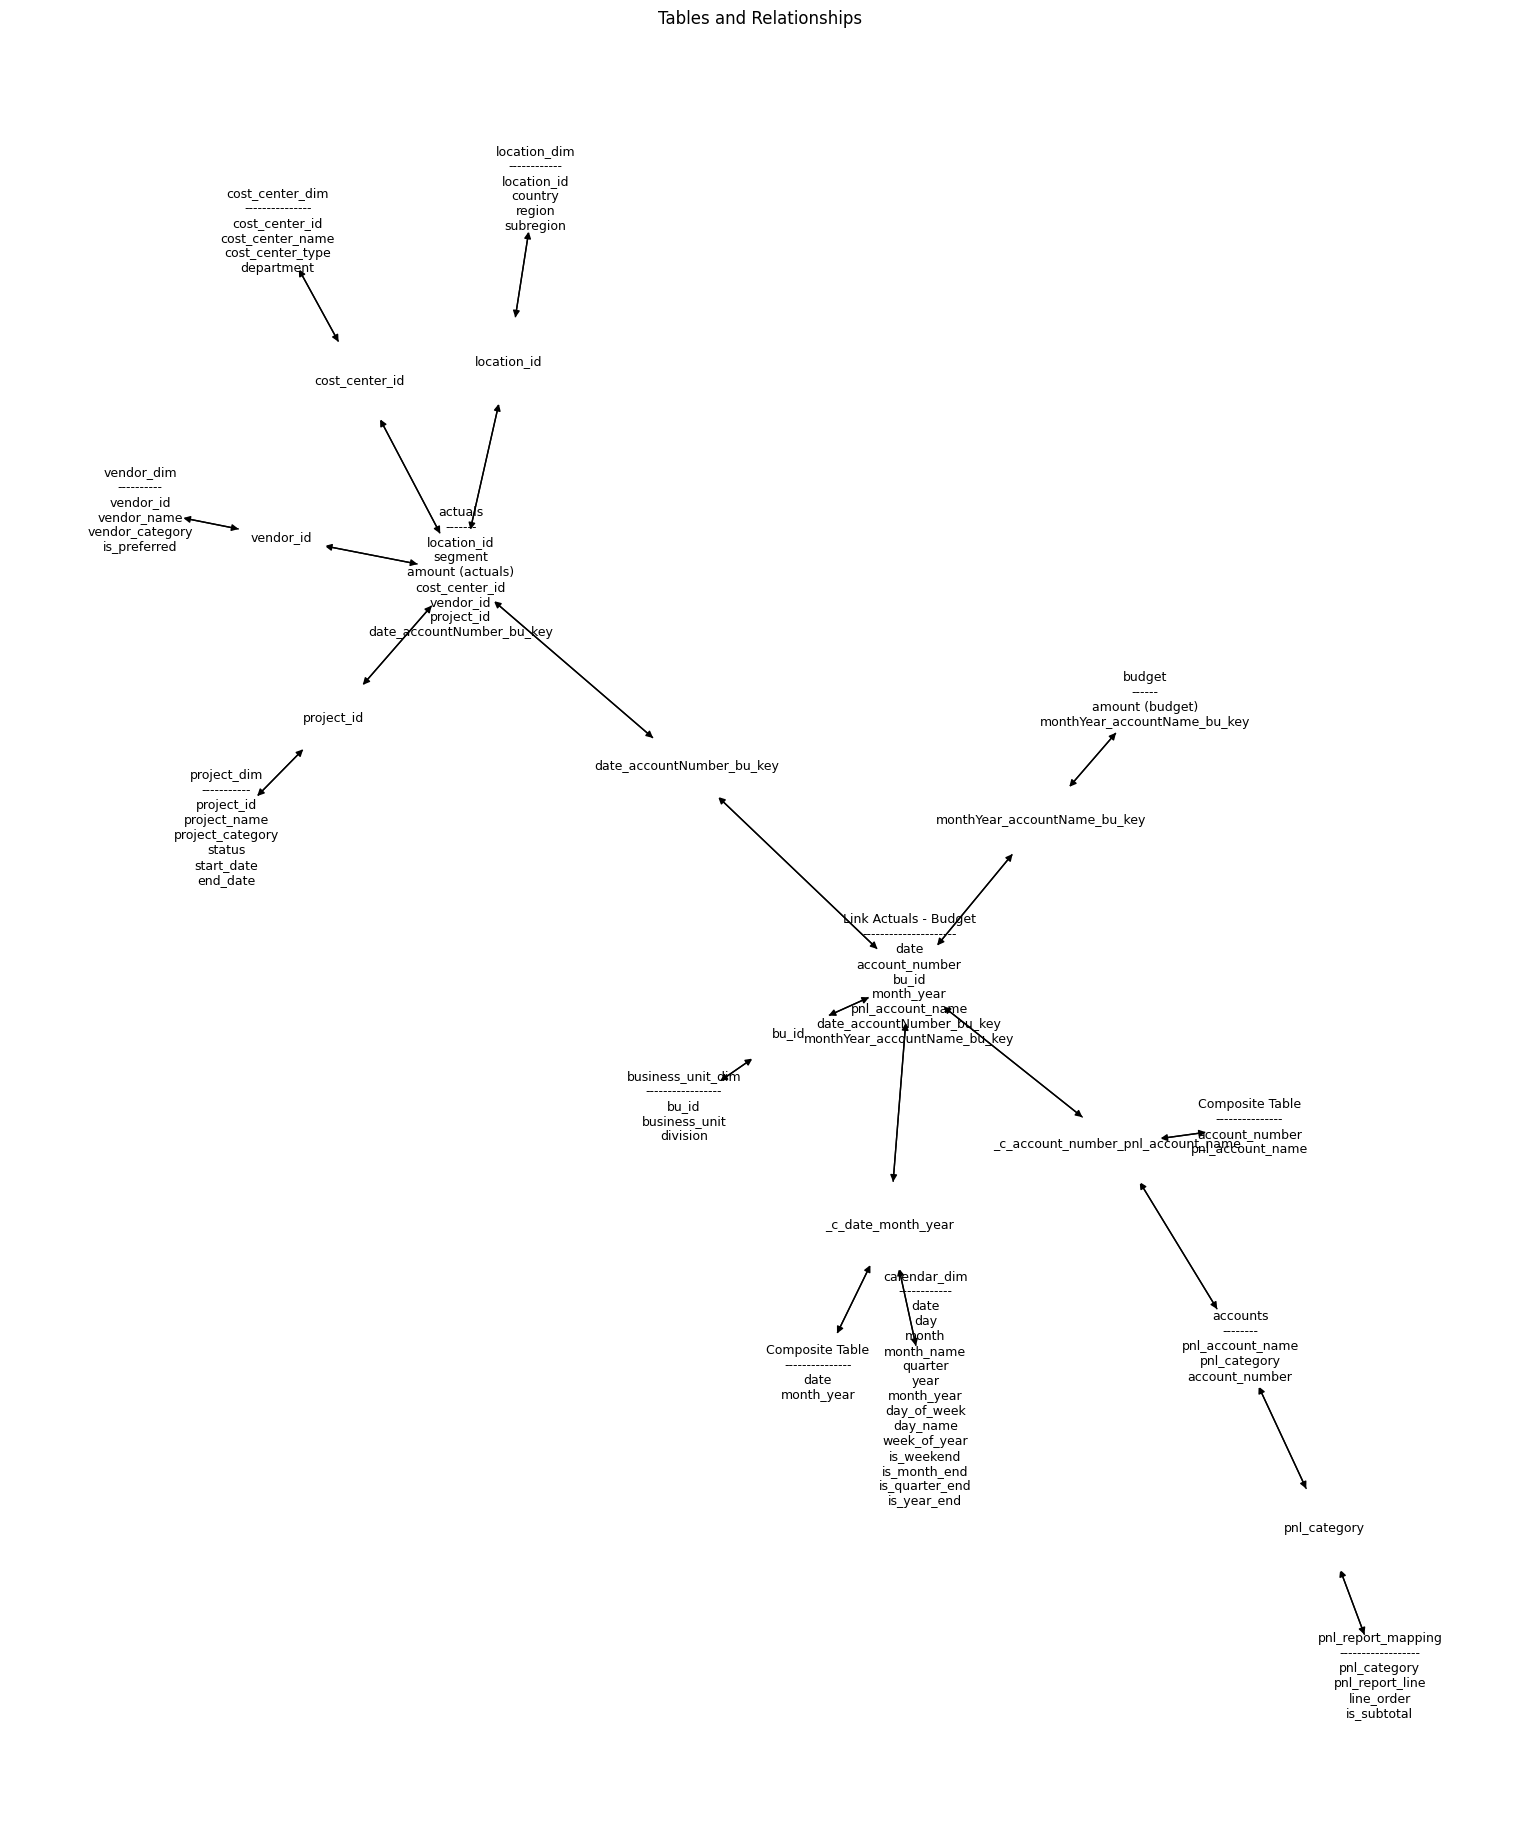

In [17]:
cube.visualize_graph(full_column_names=False,h=18,w=15)

In [15]:
cube.define_metric(name='Amount Actual', expression='[amount (actuals)]', aggregation='sum')
cube.define_metric(name='Amount Budget', expression='[amount (budget)]', aggregation='sum')
cube.define_metric(name='_line_order_avg', expression='[line_order]', aggregation='mean')

cube.define_computed_metric(name='difference', expression='[Amount Actual] - [Amount Budget]')
cube.define_computed_metric(name='percentage_difference', expression='[difference] / [Amount Budget]')

#supporting metric
cube.define_query(name='PNL', metrics=['Amount Actual', 'Amount Budget'], computed_metrics = ['difference', 'percentage_difference'], dimensions=['pnl_report_line'], sort=[('_line_order_avg', 'asc')])
cube.query('PNL')

,pnl_report_line,Amount Actual,Amount Budget,difference,percentage_difference
9,Revenue,2.110612e+06,2.121609e+06,-10997.387312,-0.005184
5,Gross Margin,1.842004e+06,1.853517e+06,-11513.326261,-0.006212
0,Cost of Goods Sold,-2.686079e+05,-2.680919e+05,-515.938949,0.001924
3,EBITDA,-2.957542e+05,-2.661478e+05,-29606.349975,0.111240
2,EBIT,-3.133562e+05,-2.836563e+05,-29699.925370,0.104704
7,Net Income,-4.021061e+05,-3.722665e+05,-29839.650195,0.080157
8,Operating Expenses,-2.137758e+06,-2.119665e+06,-18093.023714,0.008536
4,EBT,-4.021061e+05,-3.722665e+05,-29839.650195,0.080157
1,Depreciation & Amortization,-1.760205e+04,-1.750848e+04,-93.575395,0.005345
6,Interest,-8.874990e+04,-8.861017e+04,-139.724825,0.001577
